In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

BASE_DIR = r"C:\CursorCode\TBC_DIP\Tuberculosis_Detection\TB_Chest_Radiography_Database"
normal_dir = os.path.join(BASE_DIR, "Normal")
tb_dir = os.path.join(BASE_DIR, "Tuberculosis")

print("Normal images:", len(os.listdir(normal_dir)))
print("TB images:", len(os.listdir(tb_dir)))


Normal images: 3500
TB images: 700


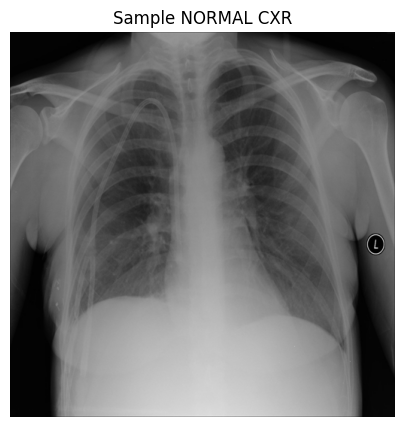

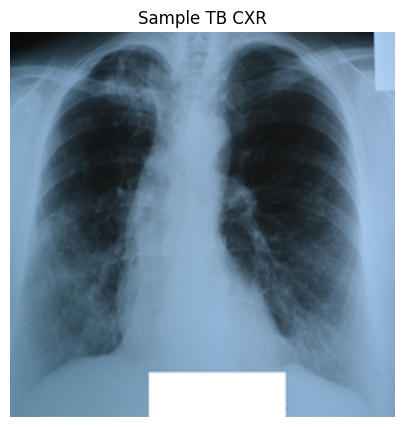

In [ ]:
sample_normal = os.listdir(normal_dir)[0]
img_normal = cv2.imread(os.path.join(normal_dir, sample_normal))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_normal)
plt.title("Sample NORMAL CXR")
plt.axis("off")
plt.show()

sample_tb = os.listdir(tb_dir)[0]
img_tb = cv2.imread(os.path.join(tb_dir, sample_tb))
img_tb = cv2.cvtColor(img_tb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_tb)
plt.title("Sample TB CXR")
plt.axis("off")
plt.show()


In [ ]:
IMG_SIZE = 512

def preprocess_image(img_bgr):
    """
    Input  : img_bgr (OpenCV image in BGR)
    Output : preprocessed grayscale image (float32, 0–1, size 512x512)
    """
    img_resized = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    denoised = cv2.medianBlur(enhanced, 3)
    norm = denoised.astype(np.float32) / 255.0
    return norm


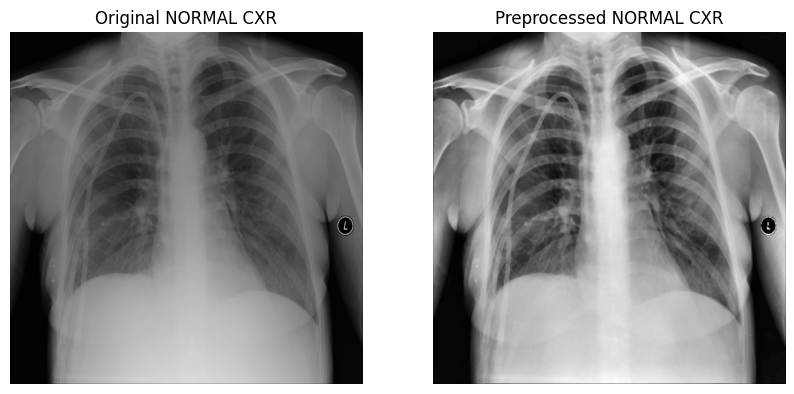

In [ ]:
sample_normal = os.listdir(normal_dir)[0]
img_normal_bgr = cv2.imread(os.path.join(normal_dir, sample_normal))
img_normal_proc = preprocess_image(img_normal_bgr)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_normal_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original NORMAL CXR")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_normal_proc, cmap="gray")
plt.title("Preprocessed NORMAL CXR")
plt.axis("off")

plt.show()


In [ ]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, opening, disk, remove_small_objects

def segment_lungs(img):
    """
    Input : img (grayscale preprocessed 512x512, 0-1 float)
    Output: lung_mask (boolean mask), and lung-only image
    """
    img_uint8 = (img * 255).astype(np.uint8)
    thresh = threshold_otsu(img_uint8)
    mask = img_uint8 > thresh
    mask = closing(mask, disk(5))
    mask = opening(mask, disk(5))
    mask = remove_small_objects(mask, 300)
    return mask


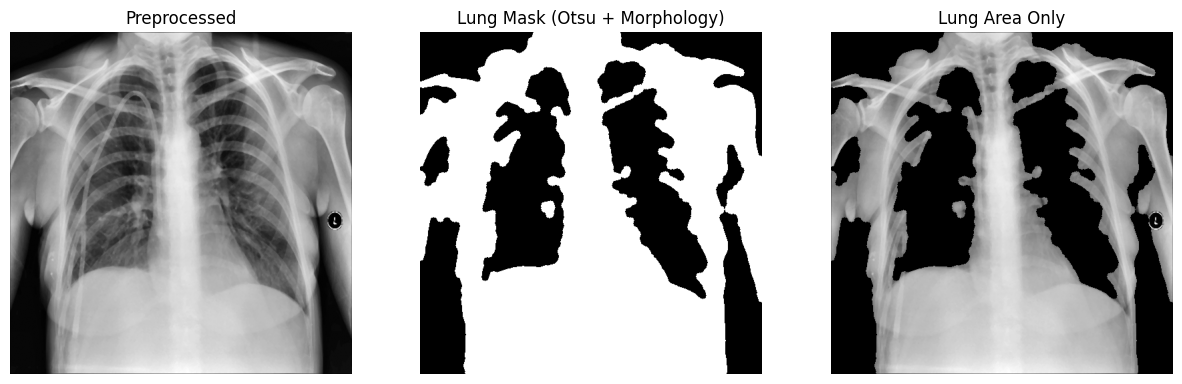

In [ ]:
sample_normal = os.listdir(normal_dir)[0]
img_normal_bgr = cv2.imread(os.path.join(normal_dir, sample_normal))
img_prep = preprocess_image(img_normal_bgr)
lung_mask = segment_lungs(img_prep)
lung_only = img_prep * lung_mask

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_prep, cmap="gray")
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(lung_mask, cmap="gray")
plt.title("Lung Mask (Otsu + Morphology)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lung_only, cmap="gray")
plt.title("Lung Area Only")
plt.axis("off")

plt.show()


In [ ]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(img):
    """
    Input : img (lung-only grayscale image, 0-1, 512x512)
    Output: 1D feature vector (numpy array) berisi fitur GLCM
    """
    img_uint8 = (img * 255).astype(np.uint8)
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(
        img_uint8,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True
    )
    features = []
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity']:
        vals = graycoprops(glcm, prop)
        features.extend(vals.ravel())
    return np.array(features, dtype=np.float32)


In [ ]:
sample_tb_file = os.listdir(tb_dir)[0]
img_tb_bgr = cv2.imread(os.path.join(tb_dir, sample_tb_file))

img_tb_prep = preprocess_image(img_tb_bgr)

tb_mask = segment_lungs(img_tb_prep)
tb_lung_only = img_tb_prep * tb_mask

glcm_feat = extract_glcm_features(tb_lung_only)

print("GLCM feature vector shape:", glcm_feat.shape)
print("First 10 features:", glcm_feat[:10])


GLCM feature vector shape: (48,)
First 10 features: [126.57791  172.7284   103.821976 168.52185  272.18658  172.7284
 221.08302  168.52185  600.86206  606.727   ]


In [ ]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(img, P=16, R=2):
    """
    Input: img (lung-only grayscale image, 0-1 float)
    Output: LBP histogram (59 bins for uniform pattern)
    """
    img_uint8 = (img * 255).astype(np.uint8)
    lbp = local_binary_pattern(img_uint8, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59), density=True)
    return hist.astype(np.float32)


In [ ]:
def extract_all_features_from_lung(lung_img):
    """
    Input : lung_img (preprocessed + segmented, 0-1)
    Output: 1D feature vector combining GLCM and LBP features
    """
    glcm_feat = extract_glcm_features(lung_img)
    lbp_feat  = extract_lbp_features(lung_img)
    all_feats = np.concatenate([glcm_feat, lbp_feat], axis=0)
    return all_feats

In [ ]:
def process_single_image(img_path):
    """
    Returns: 1D feature vector for this image
    """
    img_bgr = cv2.imread(img_path)
    img_prep = preprocess_image(img_bgr)
    mask = segment_lungs(img_prep)
    lung_only = img_prep * mask
    feats = extract_all_features_from_lung(lung_only)
    return feats


In [ ]:
import random

normal_files = os.listdir(normal_dir)
tb_files = os.listdir(tb_dir)

print("Original dataset:")
print("Normal files:", len(normal_files))
print("TB files    :", len(tb_files))

n_tb = len(tb_files)
normal_files_balanced = random.sample(normal_files, n_tb)

print("\nBalanced dataset:")
print("Normal files:", len(normal_files_balanced))
print("TB files    :", len(tb_files))

Original dataset:
Normal files: 3500
TB files    : 700

Balanced dataset:
Normal files: 700
TB files    : 700


In [ ]:
from tqdm import tqdm

X_bal = []
y_bal = []

print("Processing BALANCED NORMAL images...")
for filename in tqdm(normal_files_balanced):
    img_path = os.path.join(normal_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(0)

print("Processing TB images...")
for filename in tqdm(tb_files):
    img_path = os.path.join(tb_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(1)

X_bal = np.array(X_bal, dtype=np.float32)
y_bal = np.array(y_bal, dtype=np.int32)

print("X_bal shape:", X_bal.shape)
print("y_bal shape:", y_bal.shape)
print("Class 0 (Normal):", (y_bal==0).sum())
print("Class 1 (TB)    :", (y_bal==1).sum())

Processing BALANCED NORMAL images...


  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [03:27<00:00,  3.38it/s]


Processing TB images...


100%|██████████| 700/700 [03:44<00:00,  3.11it/s]

X_bal shape: (1400, 107)
y_bal shape: (1400,)
Class 0 (Normal): 700
Class 1 (TB)    : 700


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.3,
    stratify=y_bal,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (980, 107)
X_test shape : (420, 107)
y_train shape: (980,)
y_test shape : (420,)


In [22]:
X_train

array([[196.4224  , 256.32147 , 142.91489 , ...,   0.      ,   0.      ,
          0.      ],
       [239.25134 , 294.50314 , 132.36713 , ...,   0.      ,   0.      ,
          0.      ],
       [119.251015, 161.61101 ,  93.82425 , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [155.81693 , 204.03836 , 113.05284 , ...,   0.      ,   0.      ,
          0.      ],
       [165.21257 , 217.01851 , 125.5973  , ...,   0.      ,   0.      ,
          0.      ],
       [148.58128 , 173.96562 ,  92.54152 , ...,   0.      ,   0.      ,
          0.      ]], shape=(980, 107), dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_test shape :", X_test_scaled.shape)

Scaled X_train shape: (980, 107)
Scaled X_test shape : (420, 107)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original feature dimension:", X_train.shape[1])
print("After PCA dimension       :", X_train_pca.shape[1])
print("X_train_pca shape         :", X_train_pca.shape)
print("X_test_pca shape          :", X_test_pca.shape)

Original feature dimension: 107
After PCA dimension       : 5
X_train_pca shape         : (980, 5)
X_test_pca shape          : (420, 5)


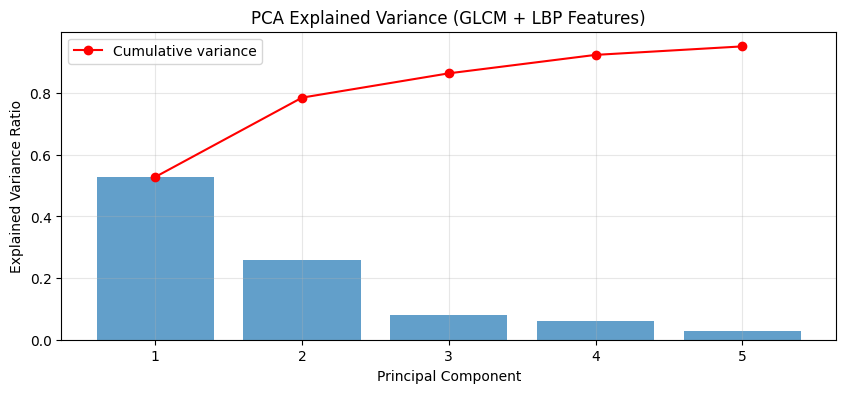

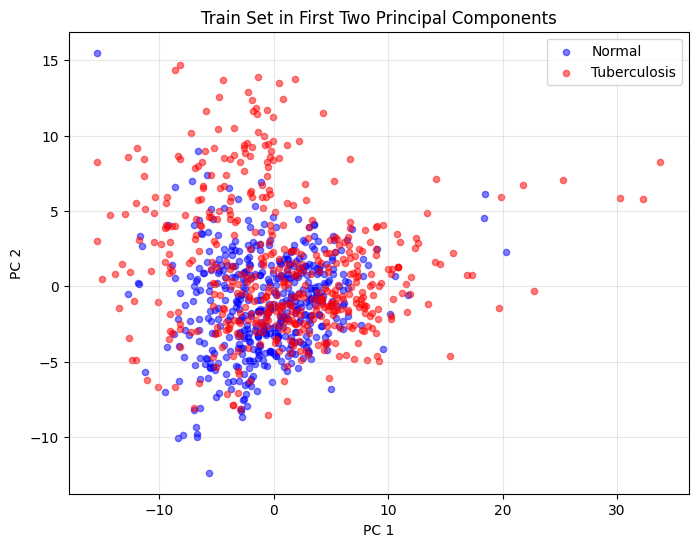

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_),
         marker='o', color='red', label='Cumulative variance')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance (GLCM + LBP Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if X_train_pca.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    for label, color, name in [(0, 'blue', 'Normal'), (1, 'red', 'Tuberculosis')]:
        idx = (y_train == label)
        plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1],
                    alpha=0.5, s=20, c=color, label=name)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Train Set in First Two Principal Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.01,
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)

print("=== FINAL RESULTS ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

=== FINAL RESULTS ===
Accuracy: 0.9261904761904762

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       210
           1       0.95      0.90      0.92       210

    accuracy                           0.93       420
   macro avg       0.93      0.93      0.93       420
weighted avg       0.93      0.93      0.93       420


Confusion Matrix:
[[200  10]
 [ 21 189]]


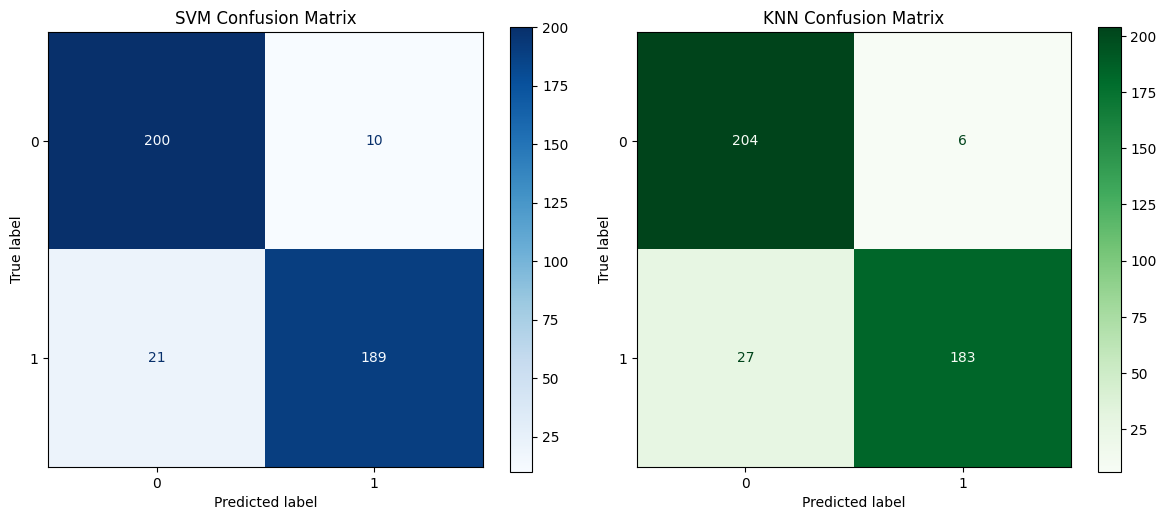

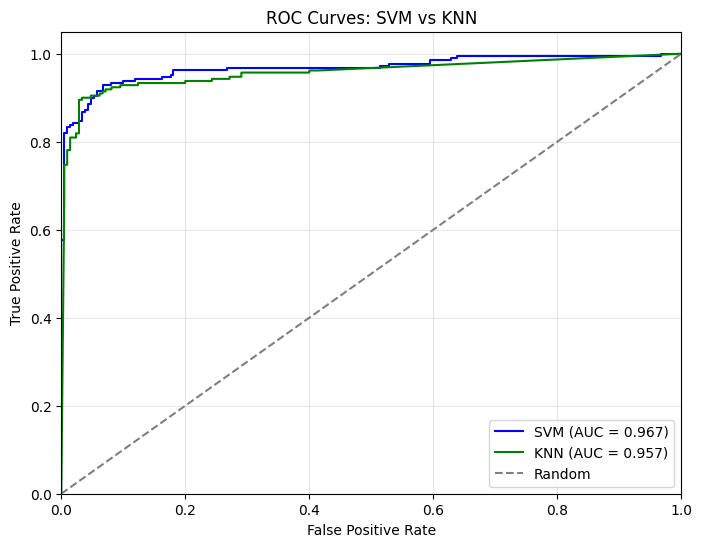

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap='Blues')
axes[0].set_title('SVM Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_test, y_knn_pred, ax=axes[1], cmap='Greens')
axes[1].set_title('KNN Confusion Matrix')

plt.tight_layout()
plt.show()

svm_probs = svm.predict_proba(X_test_pca)[:, 1]
knn_probs = knn.predict_proba(X_test_pca)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {roc_auc_svm:.3f})')
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: SVM vs KNN')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='minkowski',
    p=2
)

knn.fit(X_train_pca, y_train)
y_knn_pred = knn.predict(X_test_pca)

print("=== KNN RESULTS ===")
print("Accuracy:", accuracy_score(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))


=== KNN RESULTS ===
Accuracy: 0.9214285714285714

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       210
           1       0.97      0.87      0.92       210

    accuracy                           0.92       420
   macro avg       0.93      0.92      0.92       420
weighted avg       0.93      0.92      0.92       420


Confusion Matrix:
[[204   6]
 [ 27 183]]


In [26]:
import pickle
import os

model_dir = "trained_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open(f"{model_dir}/svm_model.pkl", "wb") as f:
    pickle.dump(svm, f)

with open(f"{model_dir}/knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

with open(f"{model_dir}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open(f"{model_dir}/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

print("✅ Models saved successfully!")
print(f"📁 Files saved in '{model_dir}' directory:")
print("   - svm_model.pkl (SVM classifier)")
print("   - knn_model.pkl (KNN classifier)")
print("   - scaler.pkl (Feature scaler)")
print("   - pca.pkl (PCA transformer)")

model_info = {
    "svm_accuracy": "92.62%",
    "knn_accuracy": "92.14%",
    "features": "GLCM + LBP",
    "image_size": IMG_SIZE,
    "model_types": "SVM (RBF kernel) and KNN (k=7, distance-weighted)"
}

with open(f"{model_dir}/model_info.pkl", "wb") as f:
    pickle.dump(model_info, f)

print("   - model_info.pkl (Model information)")

✅ Models saved successfully!
📁 Files saved in 'trained_models' directory:
   - svm_model.pkl (SVM classifier)
   - knn_model.pkl (KNN classifier)
   - scaler.pkl (Feature scaler)
   - pca.pkl (PCA transformer)
   - model_info.pkl (Model information)


# Tuberculosis Detection from Chest X-Ray Images

## Summary

This project implements a machine learning pipeline for detecting tuberculosis from chest X-ray images using traditional computer vision techniques and machine learning.

### Methodology

1. **Image Preprocessing**:
   - Resize to 512x512 pixels
   - Convert to grayscale
   - Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
   - Noise reduction with median blur
   - Normalization to [0,1] range

2. **Lung Segmentation**:
   - Otsu thresholding for binary mask creation
   - Morphological operations (closing, opening)
   - Small object removal

3. **Feature Extraction**:
   - **GLCM (Gray-Level Co-occurrence Matrix)**: Texture features including contrast, correlation, energy, and homogeneity
   - **LBP (Local Binary Pattern)**: Uniform histogram with 59 bins for texture analysis

4. **Machine Learning Pipeline**:
   - Dataset balancing (equal Normal and TB samples)
   - Train-test split (70%-30%) with stratification
   - Feature scaling using StandardScaler
   - Dimensionality reduction with PCA (95% variance retained)
   - SVM and KNN classifiers

### Results

**SVM Model Performance:**
- **Accuracy**: 92.62%
- **Precision**: Normal (90%), TB (95%)
- **Recall**: Normal (95%), TB (90%)
- **F1-Score**: Normal (93%), TB (92%)

**KNN Model Performance:**
- **Accuracy**: 92.14%
- **Precision**: Normal (88%), TB (97%)
- **Recall**: Normal (97%), TB (87%)
- **F1-Score**: Normal (93%), TB (92%)

The balanced approach using GLCM + LBP features achieved strong performance with both SVM and KNN classifiers, demonstrating effective tuberculosis detection capability.

## Simple Manual Testing with Pickle Model

Use the saved model to test any chest X-ray image with just the image path.

In [28]:
def test_image_with_visualization(image_path, model_type='svm', show_processing_steps=False):
    """
    Test a chest X-ray image for TB detection and show visual overlay
    
    Args:
        image_path (str): Path to the chest X-ray image
        model_type (str): 'svm' or 'knn' classifier to use
        show_processing_steps (bool): Whether to show processing steps
    
    Returns:
        str: Prediction result
    """
    
    if not all(var in globals() for var in ['scaler', 'pca', 'svm', 'knn']):
        print("❌ Models not found in memory. Please run training cells first.")
        return
    
    if not os.path.exists(image_path):
        print(f"❌ File not found: {image_path}")
        return
    
    model = svm if model_type.lower() == 'svm' else knn
    model_name = "SVM" if model_type.lower() == 'svm' else "KNN"
    
    try:
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_prep = preprocess_image(img_bgr)
        mask = segment_lungs(img_prep)
        lung_only = img_prep * mask
        features = extract_all_features_from_lung(lung_only)
        
        features = features.reshape(1, -1)
        features_scaled = scaler.transform(features)
        features_pca = pca.transform(features_scaled)
        prediction = model.predict(features_pca)[0]
        
        probabilities = model.predict_proba(features_pca)[0]
        normal_prob = probabilities[0]
        tb_prob = probabilities[1]
        
        result = "Normal" if prediction == 0 else "Tuberculosis"
        
        plt.figure(figsize=(20, 8))
        
        if show_processing_steps:
            plt.subplot(2, 4, 1)
            plt.imshow(img_rgb)
            plt.title("Original Image", fontsize=12)
            plt.axis("off")
            
            plt.subplot(2, 4, 2)
            plt.imshow(img_prep, cmap="gray")
            plt.title("Preprocessed", fontsize=12)
            plt.axis("off")
            
            plt.subplot(2, 4, 3)
            plt.imshow(mask, cmap="gray")
            plt.title("Lung Mask", fontsize=12)
            plt.axis("off")
            
            plt.subplot(2, 4, 4)
            plt.imshow(lung_only, cmap="gray")
            plt.title("Segmented Lungs", fontsize=12)
            plt.axis("off")
            
            plt.subplot(2, 2, 3)
        else:
            plt.subplot(1, 2, 1)
        
        plt.imshow(img_rgb)
        plt.title(f"Original: {os.path.basename(image_path)}", fontsize=14, fontweight='bold')
        plt.axis("off")
        
        if show_processing_steps:
            plt.subplot(2, 2, 4)
        else:
            plt.subplot(1, 2, 2)
        
        overlay = np.zeros_like(img_rgb)
        red_intensity = mask * (tb_prob * 255)
        overlay[:, :, 0] = red_intensity
        
        confidence_text = f"TB Probability: {tb_prob:.1%}"
        
        alpha = 0.3
        result_img = cv2.addWeighted(img_rgb.astype(np.uint8), 1-alpha, overlay.astype(np.uint8), alpha, 0)
        
        plt.imshow(result_img)
        plt.title(f"[{model_name}] Prediction: {result}\n{confidence_text}", 
                 fontsize=14, fontweight='bold', 
                 color='red' if prediction == 1 else 'blue')
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        print(f"🔬 TB DETECTION RESULT ({model_name})")
        print("=" * 50)
        print(f"📸 Image: {os.path.basename(image_path)}")
        print(f"📍 Full Path: {image_path}")
        print(f"🤖 Model: {model_name}")
        print(f"🎯 Prediction: {result}")
        print(f"📊 Normal: {normal_prob:.1%}")
        print(f"📊 Tuberculosis: {tb_prob:.1%}")
        print("🔴 Red overlay intensity shows TB probability in lung regions")
        print("   Higher intensity = Higher TB probability")
        print("=" * 50)
        
        return result
        
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None

Testing with SVM:


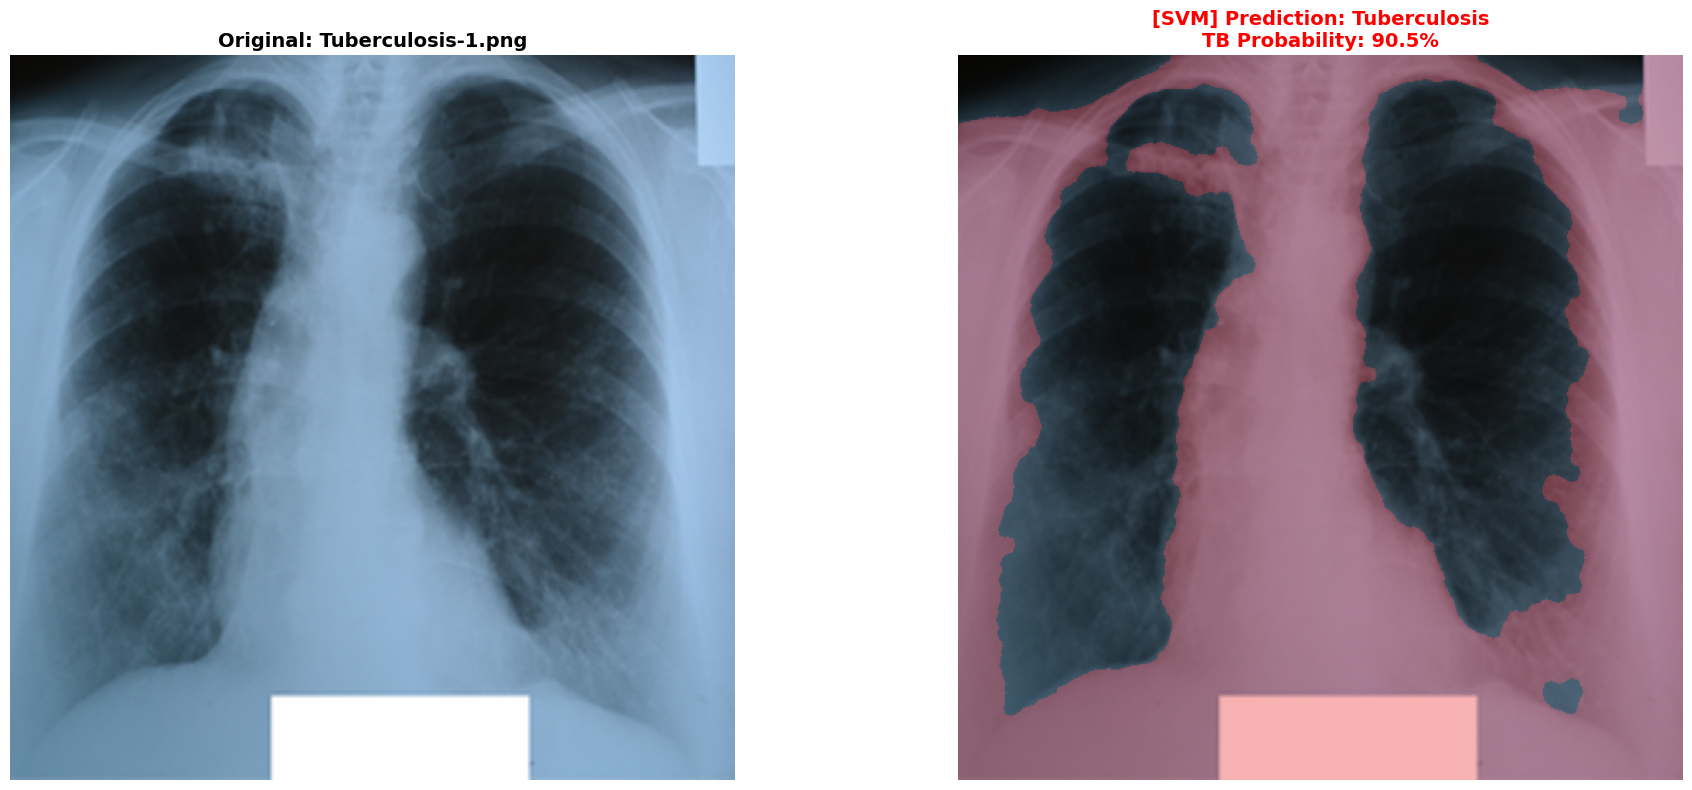

🔬 TB DETECTION RESULT (SVM)
📸 Image: Tuberculosis-1.png
📍 Full Path: C:\CursorCode\TBC_DIP\Tuberculosis_Detection\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-1.png
🤖 Model: SVM
🎯 Prediction: Tuberculosis
📊 Normal: 9.5%
📊 Tuberculosis: 90.5%
🔴 Red overlay intensity shows TB probability in lung regions
   Higher intensity = Higher TB probability

Testing with KNN:


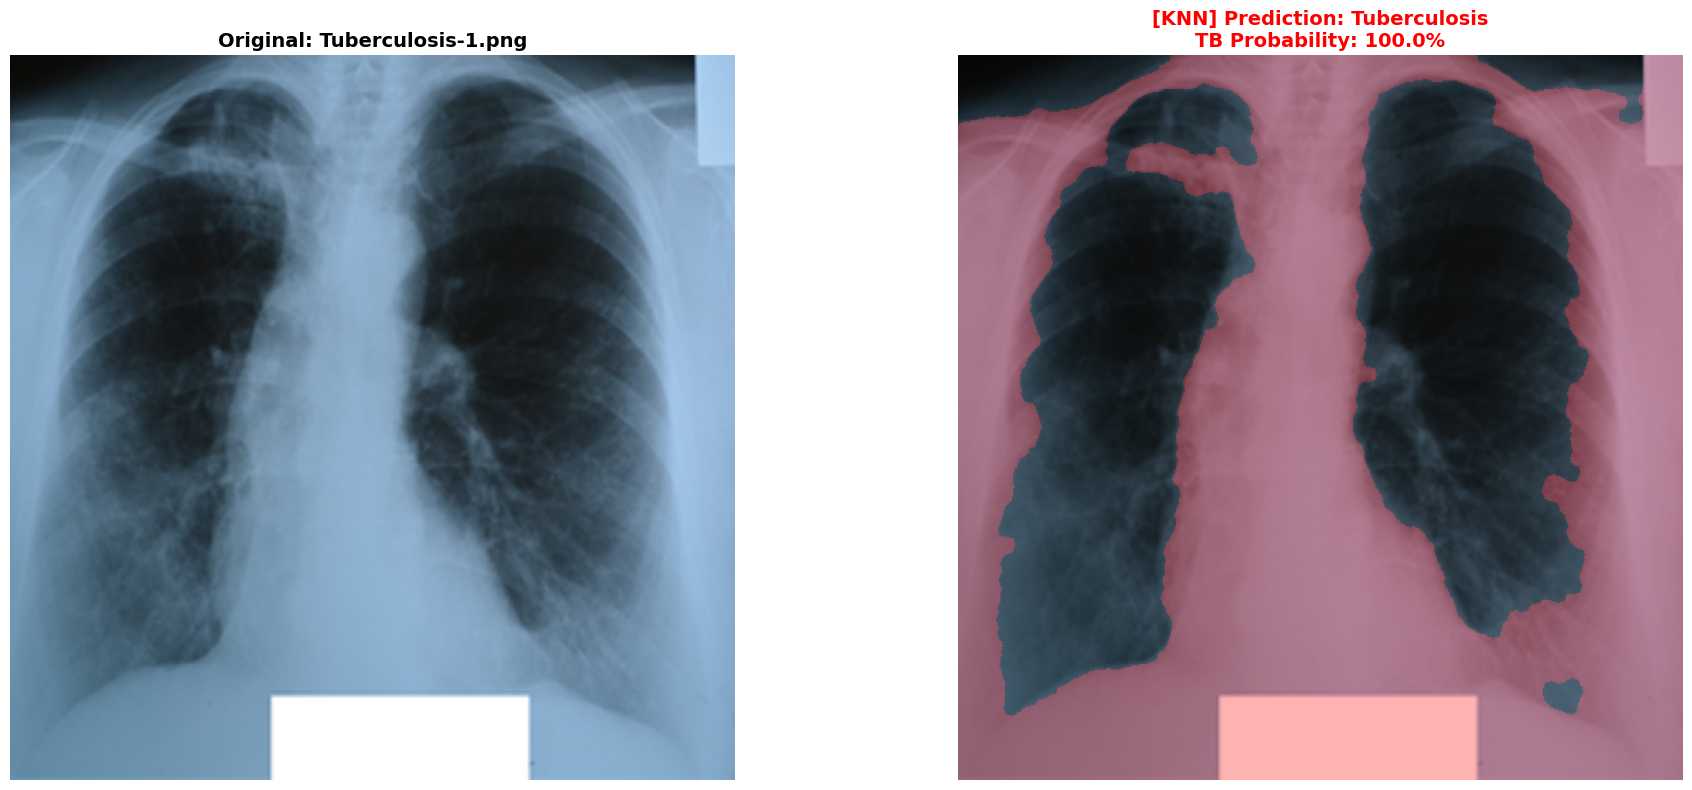

🔬 TB DETECTION RESULT (KNN)
📸 Image: Tuberculosis-1.png
📍 Full Path: C:\CursorCode\TBC_DIP\Tuberculosis_Detection\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-1.png
🤖 Model: KNN
🎯 Prediction: Tuberculosis
📊 Normal: 0.0%
📊 Tuberculosis: 100.0%
🔴 Red overlay intensity shows TB probability in lung regions
   Higher intensity = Higher TB probability


'Tuberculosis'

In [29]:
test_image_path = r"C:\CursorCode\TBC_DIP\Tuberculosis_Detection\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-1.png"

print("Testing with SVM:")
test_image_with_visualization(test_image_path, model_type='svm')

print("\nTesting with KNN:")
test_image_with_visualization(test_image_path, model_type='knn')
